In [12]:
pip install plotly.express

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Imports
import pandas as pd
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

def convert_likert_to_numeric(df, freq_cols, mapping=None):
    if mapping is None:
        mapping = {
            "Never" : 0,
            "Rarely" : 1,
            "Sometimes" : 2,
            "Often" : 3,
            "Always" : 4,

        }
    df_converted = df.copy()
    for col in freq_cols:
        df_converted[col] = df_converted[col].map(mapping).fillna(0)
    
    return df_converted


'''
Read in the music and mental health dataset to do some cleaning in order to do correlational testing.
This includes dropping unwanted columns, adding an observation count column, remapping the effects to
maintain consistency and then remapping them to a numerical value instead. We also convert the likert
scale in the dataset to numerical values with the above defined method to define the explanatory columns
before dropping unwanted columns from that dataframe as well.
'''

df = pd.read_csv("https://raw.githubusercontent.com/brobers0339/Musical_Impact_on_Mental_Health_Senior_Thesis/refs/heads/main/Music%26MentalHealthDataset.csv")

df_cleaned = df.drop(['Timestamp', 'Age', 'Primary streaming service', 'Exploratory', 'Permissions', 'BPM', 'Foreign languages'], axis=1)

df_cleaned['obs_count'] = range(1, len(df_cleaned) + 1)

df_cleaned['Effects_remapped'] = df_cleaned['Music effects'].map({
    'Improve' : 'Improved',
    'No effect' : 'No Effect',
    'Worsen' : 'Worsened',
    })

categories = {
    'Improved' : 1,
    'No Effect' : 2,
    'Worsened' : 3,
    'Unknown' : 0
}

df_cleaned['Effects_remapped'] = df_cleaned['Effects_remapped'].fillna('Unknown')
df_cleaned['Effects_remapped_cat'] = df_cleaned['Effects_remapped'].map(categories)

freq_cols = ['Frequency [Classical]', 
             'Frequency [Country]', 
             'Frequency [EDM]', 
             'Frequency [Folk]', 
             'Frequency [Gospel]', 
             'Frequency [Hip hop]', 
             'Frequency [Jazz]', 
             'Frequency [K pop]', 
             'Frequency [Latin]', 
             'Frequency [Lofi]', 
             'Frequency [Metal]', 
             'Frequency [Pop]', 
             'Frequency [R&B]', 
             'Frequency [Rap]', 
             'Frequency [Rock]', 
             'Frequency [Video game music]']


df_explanatory_cols = convert_likert_to_numeric(df_cleaned, freq_cols)
df_explanatory_cols = df_explanatory_cols.drop(['While working', 'Instrumentalist', 'Composer', 'Fav genre', 'Music effects', 'Effects_remapped', 'obs_count', 'Effects_remapped_cat'], axis=1)


In [4]:

'''
Ordinal Logisitc Regression: 
    Using ordinal logistic regression, we attempt to predict the outcome of mental health 
    symptoms from each of the music categories to determine if there are any statistically
    significant correlations present between the two categories. 
'''

#Create ordinal logistical regression model using the cleaned dataset with remapped
#effects column and the explanatory columns defined above.
model = OrderedModel(
    df_cleaned['Effects_remapped_cat'],
    df_explanatory_cols,
    distr='logit'
)

'''Fit the ordinal model using the Broyden-Fletcher-Goldfarb-Shanno
    algorithm, most popular minimizing optimization method as it improves the
    approximation of the computed Hessian matrix variables
'''
res = model.fit(method='bfgs')

#Fit model to a pandas dataframe to allow the data to be exported to a csv,
#and then therefore exported to a table to be used in the final report
model_df = pd.DataFrame({
    'Coef' : res.params,
    'Std Err' : res.bse,
    'z' : res.tvalues,
    'P>|z|' : res.pvalues,
    'CI_lower' : res.conf_int()[0],
    'CI_upper' : res.conf_int()[1]
})


Optimization terminated successfully.
         Current function value: 0.676787
         Iterations: 39
         Function evaluations: 41
         Gradient evaluations: 41


In [5]:

'''
Spearman's Rank Correlation
    Using Spearman's rank correlation testing, we measure the strength between the 
    different ranked categories in the dataset. After calculating the spearman's r-value
    and p-values, we write that information to a dataframe to store and eventually export
    to a csv file in order to be implemented into the final report and findings.
'''

#Imports
from scipy.stats import spearmanr

#Define the correlational matrix the values will be added to
spearman_matrix = {'Category' : [], 'SpearmanR' : [], 'p-value' : []}

for col in df_explanatory_cols:
    corr, pval = spearmanr(df_cleaned['Effects_remapped_cat'], df_explanatory_cols[col])
    spearman_matrix['Category'].append(col)
    spearman_matrix['SpearmanR'].append(corr)
    spearman_matrix['p-value'].append(pval)

spearman_df = pd.DataFrame(spearman_matrix)


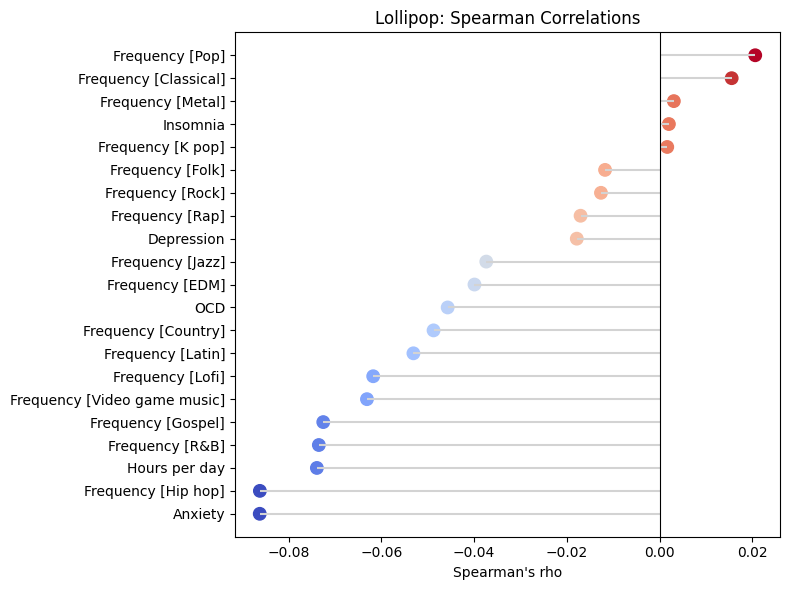

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

df = spearman_df.sort_values('SpearmanR')
plt.figure(figsize=(8,6))
plt.hlines(y=df['Category'], xmin=0, xmax=df['SpearmanR'], color='lightgray')
plt.scatter(df['SpearmanR'], df['Category'], c=df['SpearmanR'], cmap='coolwarm', s=80)
plt.axvline(0, color='k', linewidth=0.8)
plt.xlabel("Spearman's rho")
plt.title("Lollipop: Spearman Correlations")
plt.tight_layout()



C:\Users\bella\AppData\Local\Temp\ipykernel_28596\1617758673.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




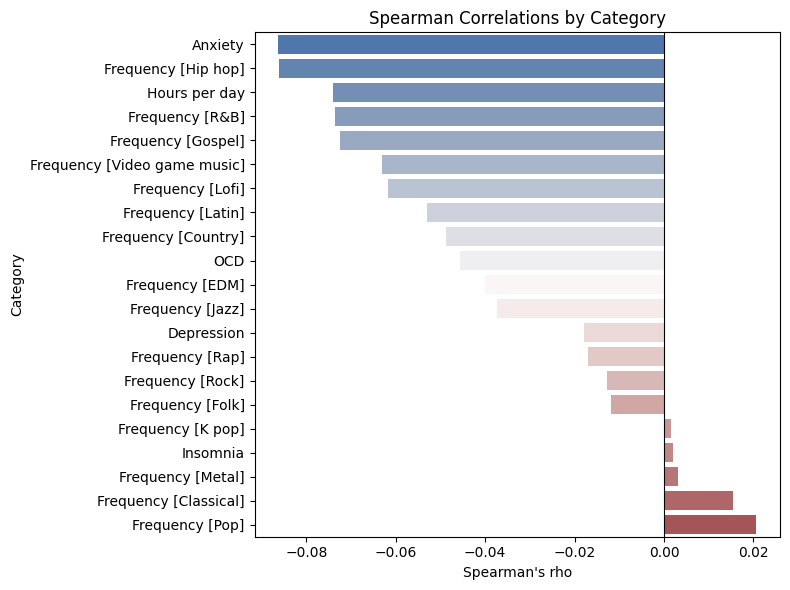

In [16]:
# sort
df = spearman_df.sort_values('SpearmanR')
plt.figure(figsize=(8,6))
sns.barplot(x='SpearmanR', y='Category', data=df, palette='vlag')
plt.axvline(0, color='k', linewidth=0.8)
plt.xlabel("Spearman's rho")
plt.title("Spearman Correlations by Category")
plt.tight_layout()